In [1]:
import os
import json
import random
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from torchvision import transforms
from typing import List, Set
from datetime import datetime
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style="whitegrid")

from deep_miml.models import Average, Attention
from deep_miml.train import train_miml_model, test_multi_instance_model
from deep_miml.utils import precision_recall_helper, get_avg_batch_precision_recall_at_k, timing
import torchvision.transforms as transforms
import torch.optim as optim
from pathlib import Path
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

/home/mridula/Projects/MIML/notebooks


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
class YelpDataset:
    def __init__(self, business_df, image_df, image_folder, transform):
        self.business_df = business_df
        self.image_df = image_df
        self.transform = transform
        self.image_folder = image_folder
        
    
    def __getitem__(self, i: int):
        b_id = self.business_df.iloc[i]['business_id']
        imgs = list(self.image_df[self.image_df['business_id'] == b_id]['photo_id'])
        
        imgs = [self.transform(Image.open(self.image_folder+f"{img}.jpg")) for img in imgs]
        
        labels = torch.FloatTensor(self.business_df.iloc[i,1:])
        
        return imgs, labels
        
    def __len__(self):
        return self.business_df.shape[0]
     
        
def collate_fn(batch, input_size=224):
    img_lists, bag_labels = zip(*batch)

    imgs = [img for img_list in img_lists for img in img_list]

    sizes = torch.LongTensor([len(img_list) for img_list in img_lists])

    bag_labels = torch.stack(bag_labels)
    

    if len(imgs) != 0:
        imgs = torch.stack(imgs)
    else:
        imgs = torch.zeros((0, 3, input_size, input_size)).float()

    return imgs, sizes, bag_labels

In [4]:
final_business_df = pd.read_csv('../../WIML/yelp_data/website_data/final_business_data.csv')
subset_images_df = pd.read_csv('../../WIML/yelp_data/website_data/subset_images_data.csv')
with open('../../WIML/yelp_data/website_data/train_test_val_split.json') as f:
    business_split_list = json.load(f)

images_folder_path = '../../WIML/yelp_data/website_data/yelp_photos/photos/'

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

test_dataset = YelpDataset(
    business_df= final_business_df[final_business_df.business_id.isin(business_split_list['test'])],
    image_df= subset_images_df,
    image_folder = images_folder_path,
    transform = data_transforms['test']
)


dataloader_test =      torch.utils.data.DataLoader(test_dataset,
                                                    batch_size= 4,
                                                    shuffle= False,
                                                    num_workers= 12,
                                                    collate_fn=collate_fn)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

                                                                              

In [6]:
model_results = []

for mn in ['resnet18', 'resnet34', 'resnet50']:
    for mt in ['avg', 'attention']:
        model = torch.load(f'/home/mridula/Projects/MIML/temp/intermediate_{mn}_{mt}_pretrained_1.pt')
        result_df = pd.DataFrame(test_multi_instance_model(model, device, dataloader_test))
        mt = 'mean_pool' if mt == 'avg' else mt
        result_df['model_type'] = mt
        result_df['model_name'] = mn
        model_results.append(result_df) 
        

100%|██████████| 125/125 [00:24<00:00,  5.03it/s]


In [7]:
exp_result_df = pd.concat(model_results)
exp_result_df.tail()

,precision_at,recall_at,model_type,model_name
2,0.955,0.364,attention,resnet50
3,0.946,0.538,attention,resnet50
4,0.921,0.693,attention,resnet50
5,0.868,0.807,attention,resnet50
6,0.805,0.892,attention,resnet50


In [54]:
def test_multi_instance_model_plus(model, device, dataloader):
    model.eval()
    ground_truth = []
    prediction = []
    with torch.no_grad():

        for inputs, sizes, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            sizes = sizes.to(device)
            labels = labels.to(device)

            if inputs.shape[0] == 0:
                # Checking batch_size >1
                continue
            category_type_logits = model(inputs, sizes)
            
            ground_truth+= list(labels)
            prediction += list(category_type_logits) # .append(category_type_logits)
            #list(torch.split(labels, 1, 0))
        list_results = [get_avg_batch_precision_recall_at_k(
            ground_truth,
            prediction,
            k) for k in range(1,7)]
        
        
        precision_avg = [r[0] for r in list_results]
        recall_avg = [r[1] for r in list_results]
        precision_std = [r[2] for r in list_results]
        recall_std = [r[3] for r in list_results]
        
    results = {}
    results["precision_avg"] = {k + 1: v for k, v in dict(enumerate(precision_avg)).items()}
    results["recall_avg"] = {k + 1: v for k, v in dict(enumerate(recall_avg)).items()}
    results["precision_std"] = {k + 1: (v/np.sqrt(len(ground_truth))) for k, v in dict(enumerate(precision_std)).items()}
    results["recall_std"] = {k + 1: (v/np.sqrt(len(ground_truth))) for k, v in dict(enumerate(recall_std)).items()}
    return results



In [55]:
model_results = []

for mn in ['resnet18', 'resnet34', 'resnet50']:
    for mt in ['avg', 'attention']:
        print(mn,mt)
        model = torch.load(f'/home/mridula/Projects/MIML/temp/intermediate_{mn}_{mt}_pretrained_1.pt')
        result_df = pd.DataFrame(test_multi_instance_model_plus(model, device, dataloader_test))
        mt = 'mean_pool' if mt == 'avg' else mt
        result_df['model_type'] = mt
        result_df['model_name'] = mn
        model_results.append(result_df) 

exp_result_df2 = pd.concat(model_results)

  0%|          | 0/125 [00:00<?, ?it/s]

resnet18 avg


  0%|          | 0/125 [00:00<?, ?it/s]

resnet18 attention


  0%|          | 0/125 [00:00<?, ?it/s]

resnet34 avg


100%|██████████| 125/125 [00:11<00:00, 10.69it/s]


resnet34 attention


100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


resnet50 avg


100%|██████████| 125/125 [00:38<00:00,  3.25it/s]


resnet50 attention


100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


In [56]:
exp_result_df.head()

,precision_at,recall_at,model_type,model_name
1,0.966,0.185,mean_pool,resnet18
2,0.949,0.362,mean_pool,resnet18
3,0.935,0.531,mean_pool,resnet18
4,0.914,0.688,mean_pool,resnet18
5,0.857,0.797,mean_pool,resnet18


In [57]:
exp_result_df2

,precision_avg,recall_avg,precision_std,recall_std,model_type,model_name
1,0.96600,0.18462,0.008105,0.002711,mean_pool,resnet18
2,0.94900,0.36158,0.007470,0.004785,mean_pool,resnet18
3,0.93498,0.53138,0.007191,0.006330,mean_pool,resnet18
4,0.91450,0.68806,0.007220,0.007166,mean_pool,resnet18
5,0.85680,0.79688,0.007016,0.006321,mean_pool,resnet18
6,0.79786,0.88428,0.006959,0.005110,mean_pool,resnet18
1,0.95600,0.18288,0.009172,0.002882,attention,resnet18
2,0.95300,0.36370,0.007388,0.004919,attention,resnet18
3,0.94300,0.53786,0.006752,0.006604,attention,resnet18
4,0.92450,0.69634,0.006845,0.007084,attention,resnet18


In [ ]:
ls

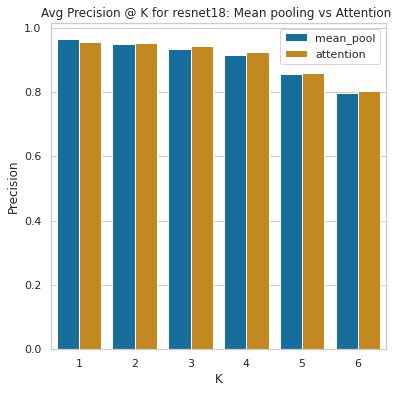

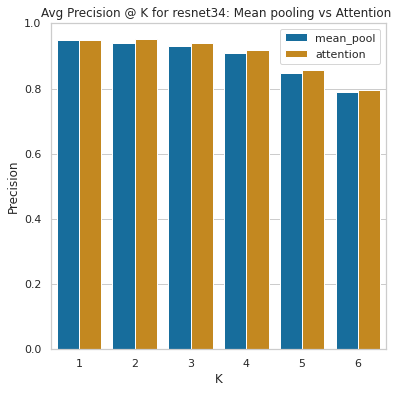

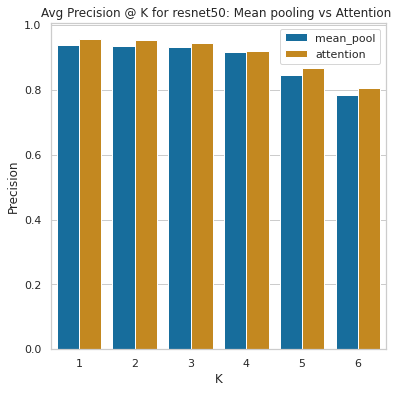

In [11]:
plt.rcParams["figure.figsize"] = (6,6)
for mn in ['resnet18', 'resnet34', 'resnet50' ]:
    plt.clf()
    
    ax = sns.barplot(x=exp_result_df[exp_result_df['model_name'] == mn].index,
                     y="precision_at", hue="model_type", 
                     data=exp_result_df[exp_result_df['model_name'] == mn],
                    palette='colorblind')
    ax.set(xlabel='K', ylabel='Precision', title = f"Avg Precision @ K for {mn}: Mean pooling vs Attention ");
    plt.legend(loc='upper right')
#     plt.savefig(f'../temp/charts/precision_{mn}.png')
    plt.show()

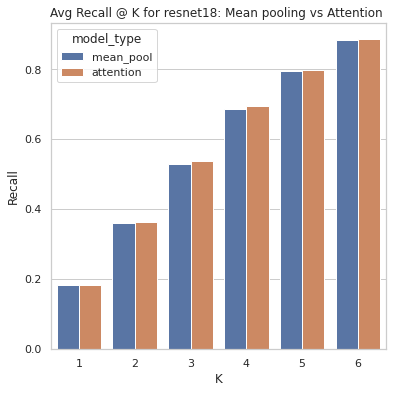

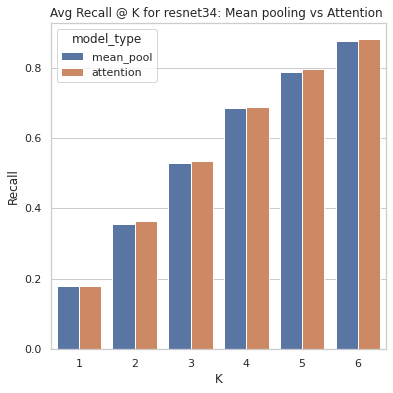

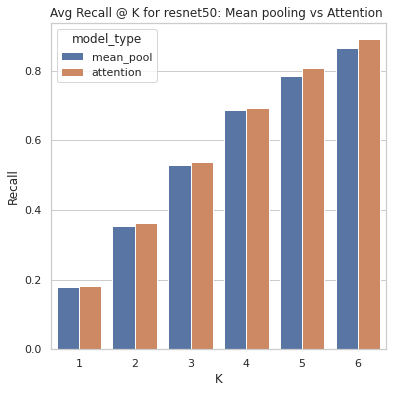

In [10]:

plt.rcParams["figure.figsize"] = (6,6)
for mn in ['resnet18', 'resnet34', 'resnet50' ]:
    plt.clf()
    ax = sns.barplot(x=exp_result_df[exp_result_df['model_name'] == mn].index,
                     y="recall_at", hue="model_type", 
                     data=exp_result_df[exp_result_df['model_name'] == mn],
                    )
    ax.set(xlabel='K', ylabel='Recall', title = f"Avg Recall @ K for {mn}: Mean pooling vs Attention ");
    
#     plt.savefig(f'../temp/charts/recall_{mn}.png')
    plt.show()